In [1]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)from scipy import stats
from scipy.stats import norm, skew #for some statistics


In [2]:
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import xgboost as xgb
import lightgbm as lgb

# Set a few plotting defaults
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 10000
pd.options.display.max_colwidth = 1000

In [3]:
#Now let's import and put the train and test datasets in  pandas dataframe

train = pd.read_csv("C:\\Users\\seung\\Desktop\\KR_data\\train.csv")
test = pd.read_csv("C:\\Users\\seung\\Desktop\\KR_data\\test.csv")
##display the first five rows of the train dataset.

In [4]:
def rmse_exp(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_true), np.expm1(y_pred)))

def train_test_split(data, do_ohe=True):
    df = data.drop(['id','price','data'], axis=1).copy()
    cat_cols = df.select_dtypes('object').columns
    for col in cat_cols:
        if do_ohe:
            ohe_df = pd.get_dummies(df[[col]], prefix='ohe_'+col)
            df.drop(col, axis=1, inplace=True)
            df = pd.concat([df, ohe_df], axis=1)
        else:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])

    train_len = data[data['data'] == 'train'].shape[0]
    X_train = df.iloc[:train_len]
    X_test = df.iloc[train_len:]
    y_train = data[data['data'] == 'train']['price']
    
    return X_train, X_test, y_train

def get_oof_lgb(X_train, y_train, X_test, lgb_param, verbose_eval=False, return_cv_score_only=False):

    folds = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    oof = np.zeros(len(X_train))
    predictions = np.zeros(len(X_test))
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, y_train.values)):
        if verbose_eval > 0: print(f'Fold : {fold_ + 1}')
        trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=y_train.iloc[trn_idx])
        val_data = lgb.Dataset(X_train.iloc[val_idx], label=y_train.iloc[val_idx])

        num_round = 100000
        clf = lgb.train(lgb_param, trn_data, num_round, valid_sets=[trn_data, val_data],
                        verbose_eval=verbose_eval, early_stopping_rounds=200)
        oof[val_idx] = clf.predict(X_train.iloc[val_idx], num_iteration=clf.best_iteration)
        predictions += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits
        
        cv_fold_score = rmse_exp(y_train.iloc[val_idx], oof[val_idx])
        
        if verbose_eval > 0: print(f'Fold {fold_ + 1} / CV-Score: {cv_fold_score:.6f}')
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df['feature'] = X_train.columns.tolist()
        fold_importance_df['importance'] = clf.feature_importance('gain')
        fold_importance_df['fold'] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    cv_score = rmse_exp(y_train, oof)
    print(f'CV-Score: {cv_score:.6f}')
    if return_cv_score_only: return cv_score
    else: return oof, predictions, cv_score, feature_importance_df
    
def plot_feature_importance(fi_df, num_feature=20):
    cols = (fi_df[['feature', 'importance']]
            .groupby('feature')
            .mean()
            .sort_values(by='importance', ascending=False)[:num_feature].index)
    best_features = fi_df.loc[fi_df.feature.isin(cols)]

    sns.barplot(x='importance', y='feature', data=best_features.sort_values(by='importance', ascending=False))
    plt.title('Feature Importances (averaged over folds)')
    plt.tight_layout()
    plt.show()
    
def plot_numeric_for_regression(df, field, target_field='price'):
    df = df[df[field].notnull()]

    fig = plt.figure(figsize = (16, 7))
    ax1 = plt.subplot(121)
    
    sns.distplot(df[df['data'] == 'train'][field], label='Train', hist_kws={'alpha': 0.5}, ax=ax1)
    sns.distplot(df[df['data'] == 'test'][field], label='Test', hist_kws={'alpha': 0.5}, ax=ax1)

    plt.xlabel(field)
    plt.ylabel('Density')
    plt.legend()
    
    ax2 = plt.subplot(122)
    
    df_copy = df[df['data'] == 'train'].copy()

    sns.scatterplot(x=field, y=target_field, data=df_copy, ax=ax2)
    
    plt.show()
    
def plot_categorical_for_regression(df, field, target_field='price', show_missing=True, missing_value='NA'):
    df_copy = df.copy()
    if show_missing: df_copy[field] = df_copy[field].fillna(missing_value)
    df_copy = df_copy[df_copy[field].notnull()]

    ax1_param = 121
    ax2_param = 122
    fig_size = (16, 7)
    if df_copy[field].nunique() > 30:
        ax1_param = 211
        ax2_param = 212
        fig_size = (16, 10)
    
    fig = plt.figure(figsize = fig_size)
    ax1 = plt.subplot(ax1_param)
    
    sns.countplot(x=field, hue='data', order=np.sort(df_copy[field].unique()), data=df_copy)
    plt.xticks(rotation=90, fontsize=11)
    
    ax2 = plt.subplot(ax2_param)
    
    df_copy = df_copy[df_copy['data'] == 'train']

    sns.boxplot(x=field, y=target_field, data=df_copy, order=np.sort(df_copy[field].unique()), ax=ax2)
    plt.xticks(rotation=90, fontsize=11)
    
    plt.show()
    
def load_original_data():
    train = pd.read_csv("C:\\Users\\seung\\Desktop\\KR_data\\train.csv")
    test = pd.read_csv("C:\\Users\\seung\\Desktop\\KR_data\\test.csv")

    train_copy = train.copy()
    train_copy['data'] = 'train'
    test_copy = test.copy()
    test_copy['data'] = 'test'
    test_copy['price'] = np.nan

    # remove outlier
    train_copy = train_copy[~((train_copy['sqft_living'] > 12000) & (train_copy['price'] < 3000000))].reset_index(drop=True)

    # concat train, test data to preprocess
    data = pd.concat([train_copy, test_copy], sort=False).reset_index(drop=True)
    data = data[train_copy.columns]

    data.drop('date', axis=1, inplace=True)
    data['zipcode'] = data['zipcode'].astype(str)

    # fix skew feature
    skew_columns = ['price']

    for c in skew_columns:
        data[c] = np.log1p(data[c])
        
    return data

In [5]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [6]:
data = load_original_data()

print(data.shape)
data.head()

(21502, 21)


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,data
0,0,12.309987,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,train
1,1,12.100718,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,train
2,2,13.142168,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,train
3,3,12.458779,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,train
4,4,12.583999,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711,train


In [7]:
X_train, X_test, y_train = train_test_split(data)
print(X_train.shape, X_test.shape)

lgb_param = {
    'objective': 'regression',
    'learning_rate': 0.05,
    'num_leaves': 15,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'feature_fraction': 0.7,
    'seed': RANDOM_SEED,
    'metric': ['rmse'],
}

oof, pred, cv_score, fi_df = get_oof_lgb(X_train, y_train, X_test, lgb_param)

(15034, 87) (6468, 87)
CV-Score: 118186.082298


# lightGBM 을 베이스 모델로, 전반적인 데이터 살펴보기.

#### Feature 중요도 살펴보기

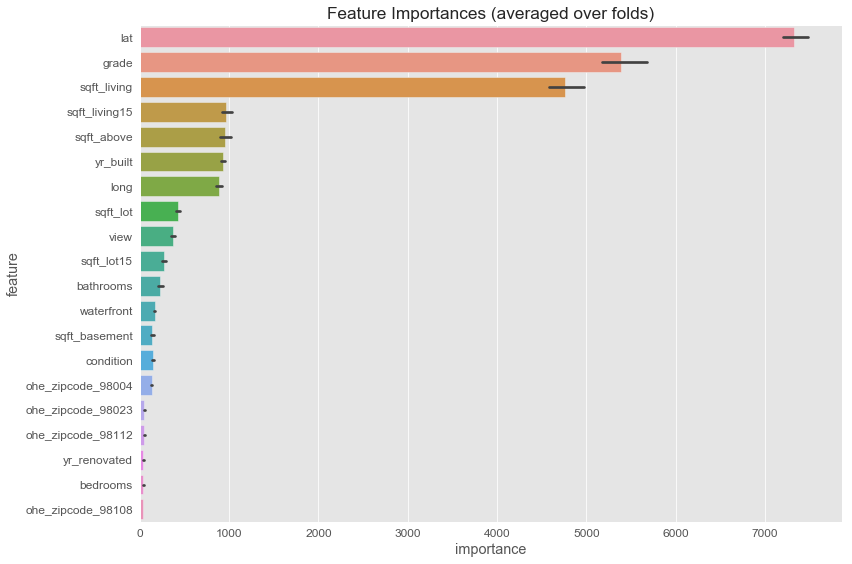

In [8]:
plot_feature_importance(fi_df)

# 데이터 상관관계 및 Feature 살펴보기 

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


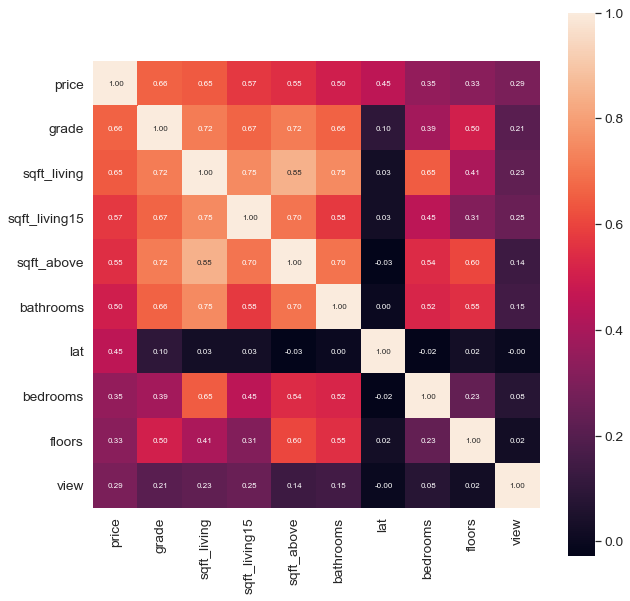

In [9]:
# correlation이 높은 상위 10개의 heatmap
# continuous + sequential variables --> spearman
# abs는 반비례관계도 고려하기 위함
# https://www.kaggle.com/junoindatascience/let-s-eda-it 준호님이 수정해 준 코드로 사용하였습니다. 
import scipy as sp

cor_abs = abs(train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

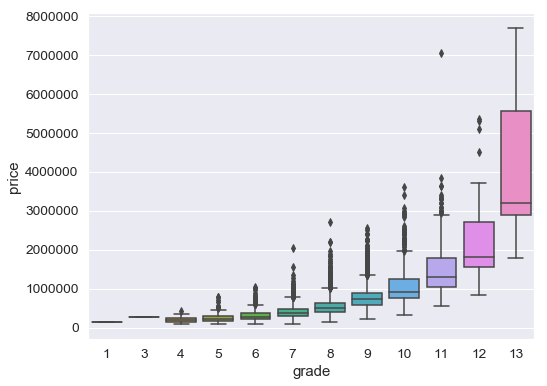

In [10]:
data = pd.concat([train['price'], train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

grade의 경우 "1-3은 건물 건축 및 디자인에 미치지 못하고 7은 평균 수준의 건축 및 디자인을, 11-13은 높은 수준의 건축 및 디자인을 지니고 있습니다." 라고 합니다.

집의 등급이 높으면 가격이 좋아지는 것은 위의 히트맵에서도 봤듯이 당연합니다. 그리고 전박적으로 상승곡선의 형태도 보이고 있습니다. 하지만

등급 3의 경우 값이 큰 이유
등급 7,8,9에서 이상치가 많은 이유
등급 8과 11에서 차이가 큰 이상치가 나타나는 이유
위의 3가지는 좀 더 자세히 살펴봐야 합니다.

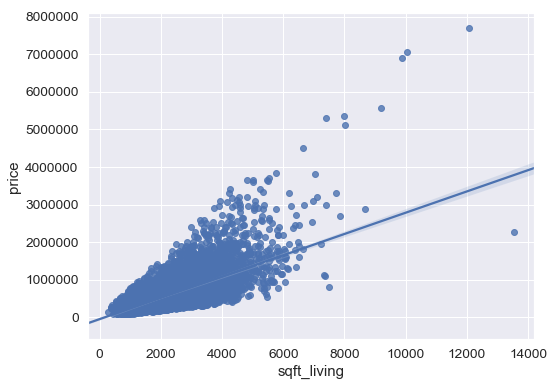

In [11]:
data = pd.concat([train['price'], train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

sqlf_living / sqlf_lot
(주거 평방 피트 / 부지 평방 피트)

1sqlf는 0.0281평입니다. sqlf_lot는 부지 평방 피트인데, 흔히 우리나라의 경우, 32평형 아파트는 일반적으로 실제로 쓰는 전용 면적은 25.7평 정도입니다.

즉, sqlf_living은 실제 사용 면적 / sqlf_lot는 총 부지의 면적으로 생각하면 됩니다.

전반적으로 선형성을 보이지만 가격이 14~15사이에 sqft_living이 14000에 가까운 값은 꽤나 이상한 값(이상치)으로 생각되어집니다. 제거할지 말지는 저 값을 확인해보고 결정하겠습니다.

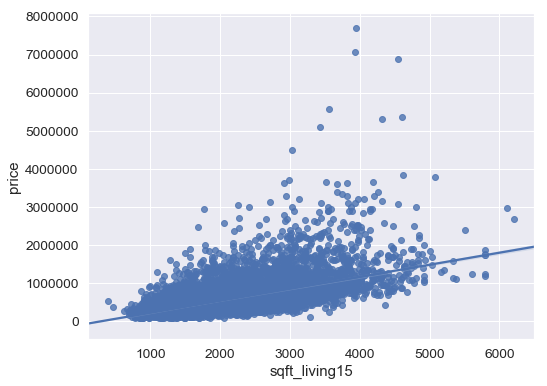

In [12]:
data = pd.concat([train['price'], train['sqft_living15']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living15', y="price", data=data)

sqft_living15의 경우 15년도를 기준으로 했다보니 sqft_living에 비해 가격의 분산이 큽니다. 아무래도 재건축으로 인한 영향일 것으로 생각되어지고 sqft_living15 그 자체를 사용하기보다는 적절한 FE이 필요해 보입니다.

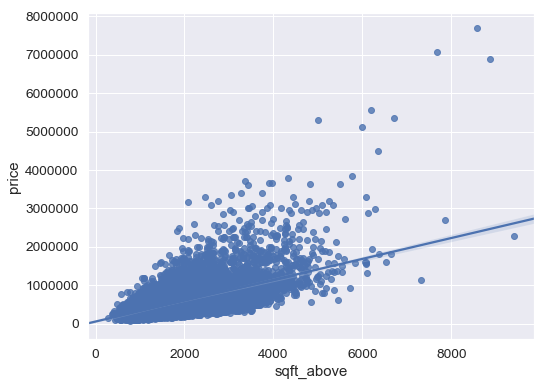

In [13]:
data = pd.concat([train['price'], train['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_above', y="price", data=data)

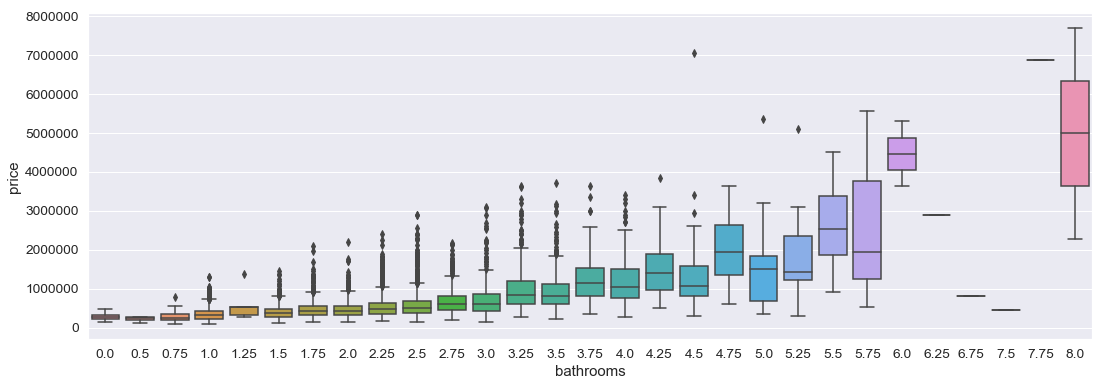

In [14]:
data = pd.concat([train['price'], train['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bathrooms', y="price", data=data)

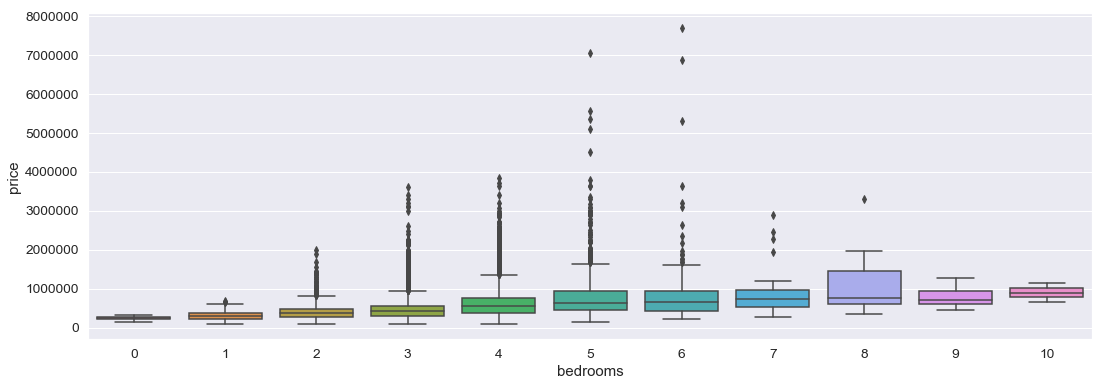

In [15]:
data = pd.concat([train['price'], train['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=data)

# data 전처리

## 아웃라이어 분석

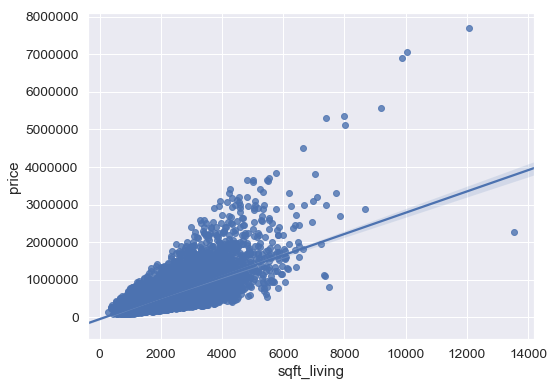

In [16]:
#sqft_living
data = pd.concat([train['price'], train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

In [17]:
train.loc[train['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,20140505T000000,2280000.0,7,8.0,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [18]:
# 이상치라 판단 제거
train = train.loc[train['id']!=8990]

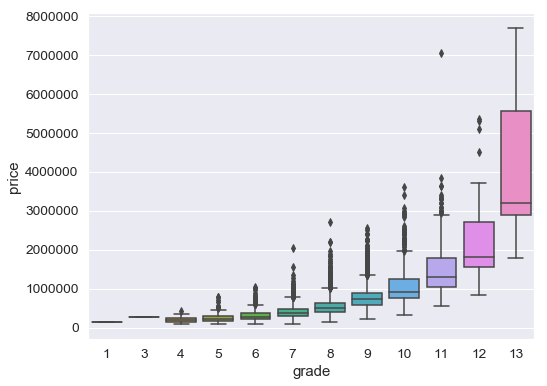

In [19]:
#grade
data = pd.concat([train['price'], train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

In [20]:
train.loc[(train['price']>12) & (train['grade'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,20150225T000000,262000.0,1,0.75,520,12981,1.0,0,0,5,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,20141104T000000,280000.0,1,0.00,600,24501,1.0,0,0,2,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


In [21]:
# 등급이 3인데 가격이 높다.
#가장 중요한 변수인 grade, sqft_ 모두 낮은 것을 볼 수 있습니다. 그래서 두 값 모두 이상치로 규정하고 제거하도록 하겠습니다.
train = train.loc[train['id']!=2302]
train = train.loc[train['id']!=4123]

In [22]:
train.loc[(train['price']>1800000) & (train['grade'] == 7)]
# 가격이 좀 비싼듯? 다른 커널들은 안지우던데 왜 안지우지, 일단 지워보자

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
12346,12346,20150115T000000,2050000.0,4,3.25,3580,19989,1.5,1,4,4,7,3480,100,1915,1965,98125,47.7087,-122.276,2410,6389


In [23]:
train = train.loc[train['id']!=12346]

In [24]:
train.loc[(train['price']>2500000) & (train['grade'] == 8)]
#이거도 지우자

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,7173,20140813T000000,2700000.0,5,4.0,4230,27295,2.0,1,4,3,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295


In [25]:
train = train.loc[train['id']!=7173]

In [26]:
train.loc[(train['price']>6000000) & (train['grade'] == 11)]
#너무 비싸다 지우자

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611T000000,7062500.0,5,4.5,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


In [27]:
train = train.loc[train['id']!=2775]

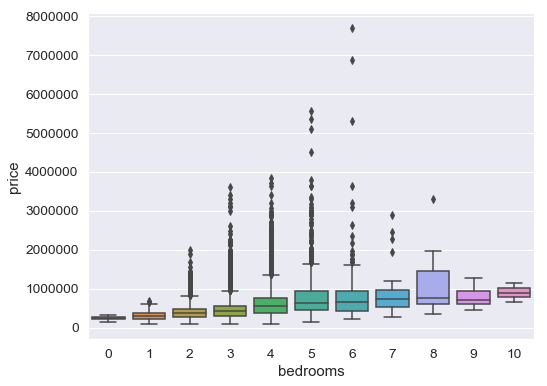

In [28]:
#bedrooms
data = pd.concat([train['price'], train['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=data)

침실의 수를 보면 위에서 한 얘기와 마찬가지로 median이 양의 상관관계를 띄고 있습니다. 그리고 bedrooms가 2 ~ 6은 분산이 매우 큰 것을 확인할 수 있습니다. 가운데의 저 값들은 다른 변수들의 영향이 크므로 위의 정보만을 보고 제거하지는 않도록 하겠습니다.

## 정규화 하기.

### Target Variable

In [29]:
# #price 그려보기

# sns.distplot(train['price'] , fit=norm);

# # Get the fitted parameters used by the function
# (mu, sigma) = norm.fit(train['price'])
# print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# #Now plot the distribution
# plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
#             loc='best')
# plt.ylabel('Frequency')
# plt.title('price distribution')

# #Get also the QQ-plot
# fig = plt.figure()
# res = stats.probplot(train['price'], plot=plt)
# plt.show()

### log로 price 정규분포화 하기

In [30]:
#정규 분포 만들기 

#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["price"] = np.log1p(train["price"])

# #Check the new distribution 
# sns.distplot(train['price'] , fit=norm);

# # Get the fitted parameters used by the function
# (mu, sigma) = norm.fit(train['price'])
# print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# #Now plot the distribution
# plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
#             loc='best')
# plt.ylabel('Frequency')
# plt.title('SalePrice distribution')

# #Get also the QQ-plot
# fig = plt.figure()
# res = stats.probplot(train['price'], plot=plt)
# plt.show()

#### ? 일부 커널은 피쳐들도 정규화를 해주던데, 해주고 안해주고 차이??

skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    df_train[c] = np.log1p(df_train[c].values)
    df_test[c] = np.log1p(df_test[c].values)

# 전처리 (Feature Engineering)

###   리모델링 안된 집은 해당년도를 집어넣는다

In [31]:
# 리모델링 안된 집은 해당년도를 집어넣는다
for df in [train,test]:
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

###   방 갯수와 화장실 갯수 합치기

In [32]:
# 방 갯수와 화장실 갯수 합치기.
for df in [train,test]:
    # 방의 전체 갯수 
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    

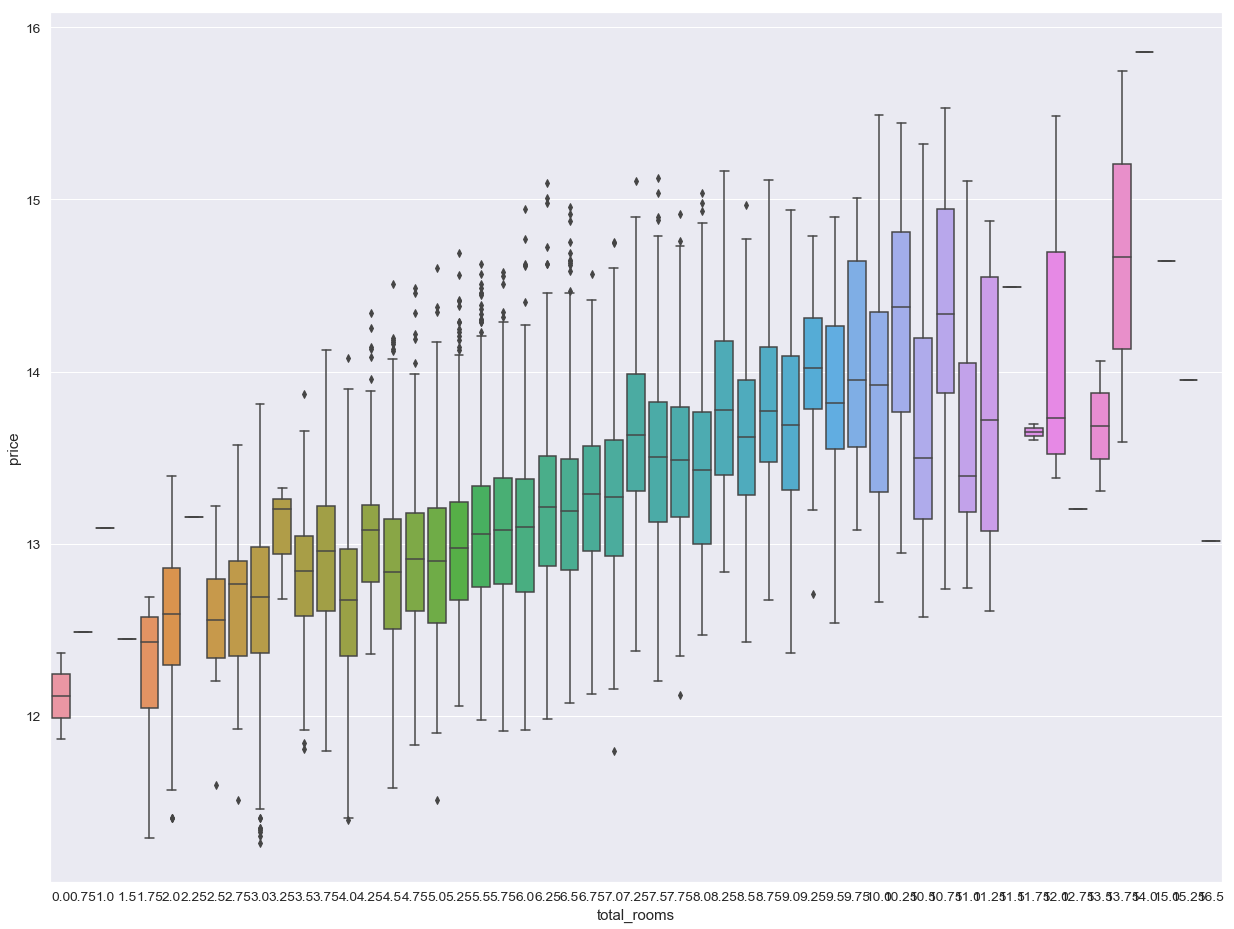

In [33]:
#total rooms 와 price 시각화
data = pd.concat([train['price'], train['total_rooms']], axis=1)
f, ax = plt.subplots(figsize=(21, 16))
fig = sns.boxplot(x='total_rooms', y="price", data=data)

### 많은 커널이 sqft_living 과 sqft_lot을 합치는데, 좋은 상관관계를 보이는 living을 굳이 합쳐서 안좋은 데이터를 만들 필요가 있나? 그래프가 좋은 그래프인가?

In [34]:
# # 주거 공간과 부지의 평방 피트 합치기

# for df in [train,test]:
#     df['sqft_total'] = df['sqft_living'] + df['sqft_lot']

In [35]:
# #sqft_living
# data = pd.concat([train['price'], train['sqft_total']], axis=1)
# f, ax = plt.subplots(figsize=(8, 6))
# fig = sns.regplot(x='sqft_total', y="price", data=data)

### 지하실제외 면적과 지하실 면적 합치기

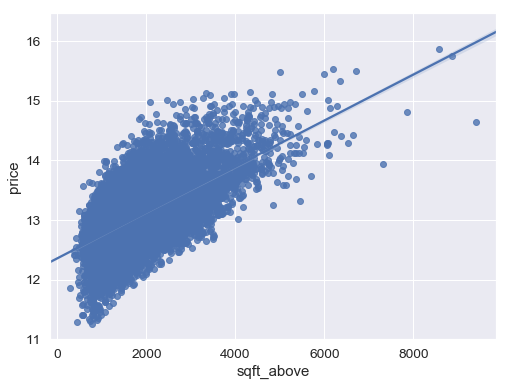

In [36]:
# 지하실 면적과 proice 관계
data = pd.concat([train['price'], train['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_above', y="price", data=data)

In [37]:
for df in [train,test]:
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement']

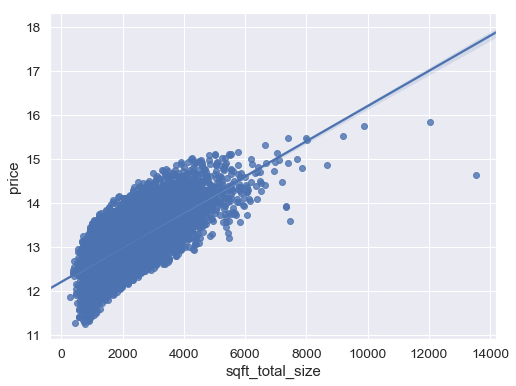

In [38]:
# 지하실 면적 + 지상 면적과 proice 관계
data = pd.concat([train['price'], train['sqft_total_size']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_total_size', y="price", data=data)

In [39]:
# OK 모양 이쁨

### 리모델링 여부

In [40]:

    # 재건축 여부 
for df in [train,test]:
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)

### 위도 경도 피쳐 분석

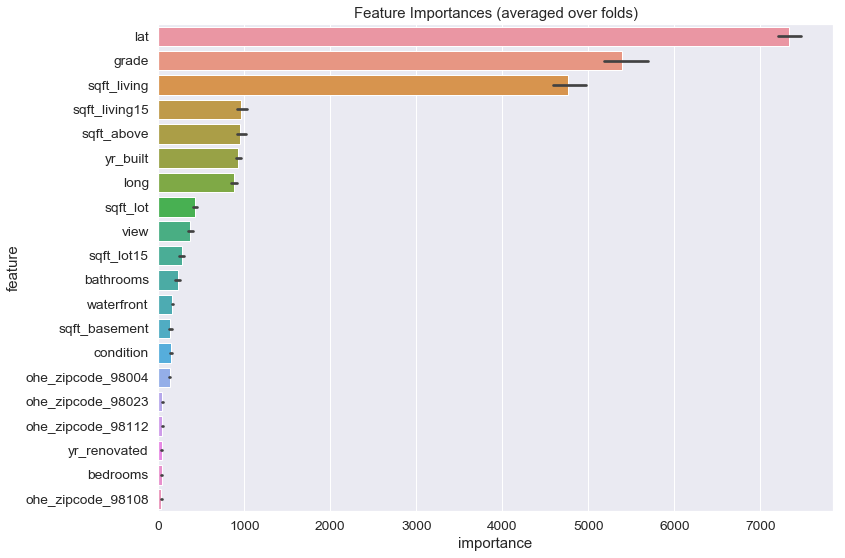

In [41]:
plot_feature_importance(fi_df)

Feature Importance를 보면 zipcode의 98004, 98023, 98112, 98108이 중요한 feature로 나오는데요.

zipcode와 price의 boxplot을 그려보면 98004, 98112는 집값이 비싼 지역 98023, 98108은 집값이 낮은 지역임을 알 수 있습니다.

98004, 98112, 98023, 98108 지역이 어느 위치에 있는지 위도, 경도 데이터를 통해 확인해보겠습니다.

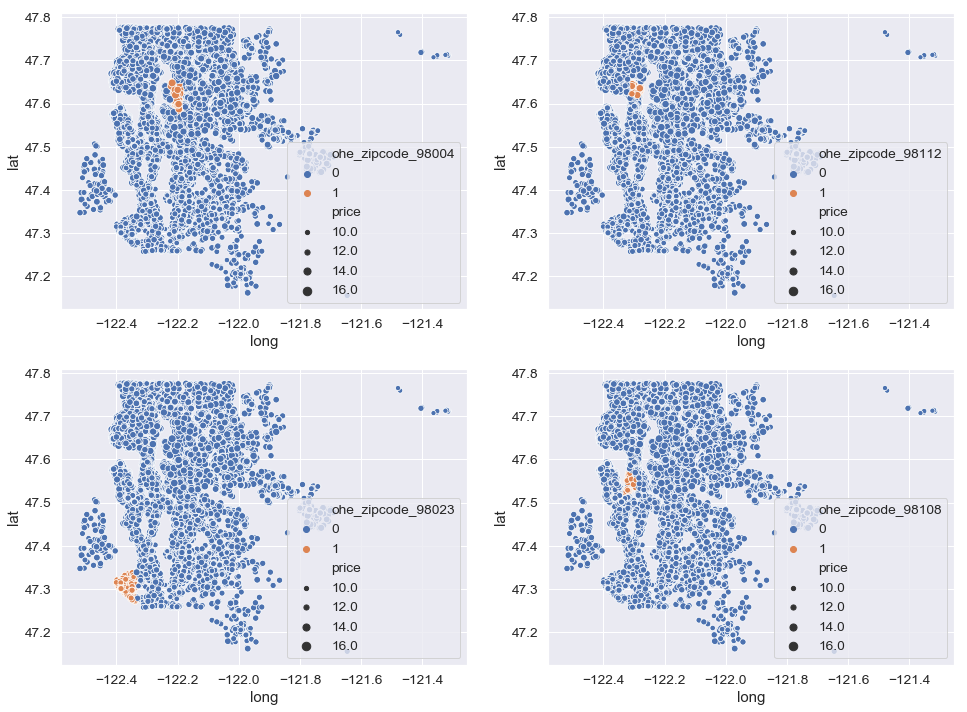

In [42]:
df = X_train
df['price'] = y_train

fig = plt.figure(figsize = (16, 12))

ax1 = plt.subplot(221)
sns.scatterplot(x='long', y='lat', hue='ohe_zipcode_98004', size='price', data=df, ax=ax1)

ax2 = plt.subplot(222)
sns.scatterplot(x='long', y='lat', hue='ohe_zipcode_98112', size='price', data=df, ax=ax2)

ax3 = plt.subplot(223)
sns.scatterplot(x='long', y='lat', hue='ohe_zipcode_98023', size='price', data=df, ax=ax3)

ax4 = plt.subplot(224)
sns.scatterplot(x='long', y='lat', hue='ohe_zipcode_98108', size='price', data=df, ax=ax4)

plt.show()

## Zipcode Feature Engineering¶

Zipcode는 다섯자리로 된 숫자형의 데이터인데, 데이터를 보면 앞의 두 자리는 98로 동일합니다.

그래서 뒤의 세 자리의 숫자를 여러가지 방법으로 쪼개서 새로운 feature를 만들어보겠습니다.

In [43]:
data = load_original_data()

data['zipcode-3'] = 'z_' + data['zipcode'].str[2:3]
data['zipcode-4'] = 'z_' + data['zipcode'].str[3:4]
data['zipcode-5'] = 'z_' + data['zipcode'].str[4:5]
data['zipcode-34'] = 'z_' + data['zipcode'].str[2:4]
data['zipcode-45'] = 'z_' + data['zipcode'].str[3:5]
data['zipcode-35'] = 'z_' + data['zipcode'].str[2:3] + data['zipcode'].str[4:5]

print(data.shape)
data.head()

(21502, 27)


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,data,zipcode-3,zipcode-4,zipcode-5,zipcode-34,zipcode-45,zipcode-35
0,0,12.309987,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,train,z_1,z_7,z_8,z_17,z_78,z_18
1,1,12.100718,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,train,z_0,z_2,z_8,z_02,z_28,z_08
2,2,13.142168,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,train,z_0,z_7,z_4,z_07,z_74,z_04
3,3,12.458779,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,train,z_0,z_0,z_3,z_00,z_03,z_03
4,4,12.583999,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711,train,z_1,z_9,z_8,z_19,z_98,z_18


### 데이터에 적용하기.

In [44]:
for df in [train,test]:
    df['zipcode'] = df['zipcode'].astype(str)

In [45]:
for df in [train,test]:
    df['zipcode-3'] = 'z_' + df['zipcode'].str[2:3]
    df['zipcode-4'] = 'z_' + df['zipcode'].str[3:4]
    df['zipcode-5'] = 'z_' + df['zipcode'].str[4:5]
    df['zipcode-34'] = 'z_' + df['zipcode'].str[2:4]
    df['zipcode-45'] = 'z_' + df['zipcode'].str[3:5]
    df['zipcode-35'] = 'z_' + df['zipcode'].str[2:3] + df['zipcode'].str[4:5]
    

In [46]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,total_rooms,sqft_total_size,is_renovated,zipcode-3,zipcode-4,zipcode-5,zipcode-34,zipcode-45,zipcode-35
0,0,20141013T000000,12.309987,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,1955.0,98178,47.5112,-122.257,1340,5650,4.00,1180,0,z_1,z_7,z_8,z_17,z_78,z_18
1,1,20150225T000000,12.100718,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,1933.0,98028,47.7379,-122.233,2720,8062,3.00,770,0,z_0,z_2,z_8,z_02,z_28,z_08
2,2,20150218T000000,13.142168,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,1987.0,98074,47.6168,-122.045,1800,7503,5.00,1680,0,z_0,z_7,z_4,z_07,z_74,z_04
3,3,20140627T000000,12.458779,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,1995.0,98003,47.3097,-122.327,2238,6819,5.25,1715,0,z_0,z_0,z_3,z_00,z_03,z_03
4,4,20150115T000000,12.583999,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,1963.0,98198,47.4095,-122.315,1650,9711,4.50,1060,0,z_1,z_9,z_8,z_19,z_98,z_18


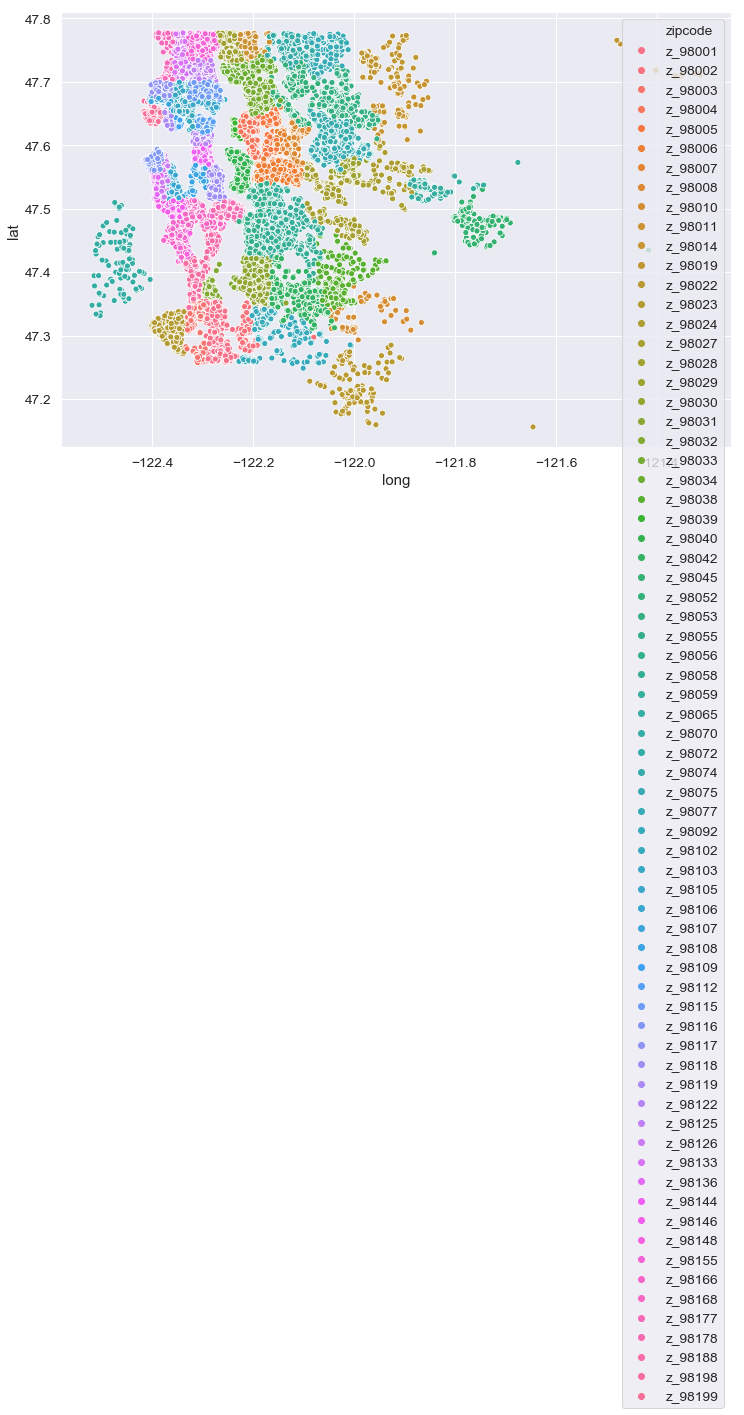

In [47]:
#새로만든 피쳐 살펴보기
data['zipcode'] = 'z_' + data['zipcode']
sns.scatterplot(x='long', y='lat', hue='zipcode', hue_order=np.sort(data['zipcode'].unique()), data=data);

## todo: zip코드 engineering 커널 다시 살펴보고 이해하기.

### PCA Transformation - Lat, Long¶

PCA는 차원축소에 주로 사용되는 알고리즘입니다. 위도, 경도의 데이터만 보면 2차원의 데이터인데, 이 데이터를 차원축소는 하지 않고 2차원 그대로 PCA Transformation을 하면 원본 데이터를 변형해서 새로운 feature를 만들 수 있습니다.

In [48]:
# # pca for lat, long
# data = load_original_data()

# coord = data[['lat','long']]
# pca = PCA(n_components=2)
# pca.fit(coord)

# coord_pca = pca.transform(coord)

# data['coord_pca1'] = coord_pca[:, 0]
# data['coord_pca2'] = coord_pca[:, 1]

In [49]:
# sns.scatterplot(x='coord_pca2', y='coord_pca1', hue='price', data=data);

X_train, X_test, y_train = train_test_split(data)
print(X_train.shape, X_test.shape)

lgb_param = {
    'objective': 'regression',
    'learning_rate': 0.05,
    'num_leaves': 15,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'feature_fraction': 0.7,
    'seed': RANDOM_SEED,
    'metric': ['rmse'],
}

oof, pred, cv_score, fi_df = get_oof_lgb(X_train, y_train, X_test, lgb_param)

In [50]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,total_rooms,sqft_total_size,is_renovated,zipcode-3,zipcode-4,zipcode-5,zipcode-34,zipcode-45,zipcode-35
0,0,20141013T000000,12.309987,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,1955.0,98178,47.5112,-122.257,1340,5650,4.00,1180,0,z_1,z_7,z_8,z_17,z_78,z_18
1,1,20150225T000000,12.100718,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,1933.0,98028,47.7379,-122.233,2720,8062,3.00,770,0,z_0,z_2,z_8,z_02,z_28,z_08
2,2,20150218T000000,13.142168,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,1987.0,98074,47.6168,-122.045,1800,7503,5.00,1680,0,z_0,z_7,z_4,z_07,z_74,z_04
3,3,20140627T000000,12.458779,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,1995.0,98003,47.3097,-122.327,2238,6819,5.25,1715,0,z_0,z_0,z_3,z_00,z_03,z_03
4,4,20150115T000000,12.583999,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,1963.0,98198,47.4095,-122.315,1650,9711,4.50,1060,0,z_1,z_9,z_8,z_19,z_98,z_18


### 적용하기


In [51]:
# for df in [train,test]:
#     coord = df[['lat','long']]
#     pca = PCA(n_components=2)
#     pca.fit(coord)

#     coord_pca = pca.transform(coord)

#     df['coord_pca1'] = coord_pca[:, 0]
#     df['coord_pca2'] = coord_pca[:, 1]


In [52]:
coord1 = train[['lat','long']]
pca1 = PCA(n_components=2)
pca1.fit(coord1)

coord_pca1 = pca1.transform(coord1)

train['coord_pca1'] = coord_pca1[:, 0]
train['coord_pca2'] = coord_pca1[:, 1]


In [53]:
coord2 = test[['lat','long']]
pca2 = PCA(n_components=2)
pca2.fit(coord1)

coord_pca2 = pca2.transform(coord2)

test['coord_pca1'] = coord_pca2[:, 0]
test['coord_pca2'] = coord_pca2[:, 1]

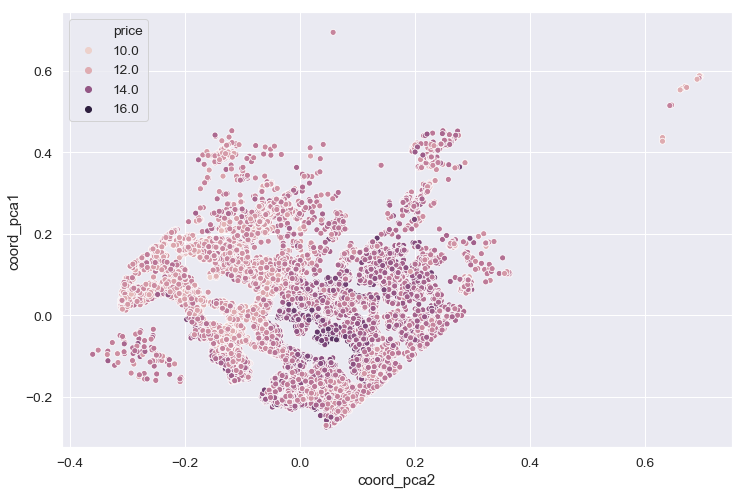

In [54]:
sns.scatterplot(x='coord_pca2', y='coord_pca1', hue='price', data=train);

X_train, X_test, y_train = train_test_split(data)
print(X_train.shape, X_test.shape)

lgb_param = {
    'objective': 'regression',
    'learning_rate': 0.05,
    'num_leaves': 15,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'feature_fraction': 0.7,
    'seed': RANDOM_SEED,
    'metric': ['rmse'],
}

oof, pred, cv_score, fi_df = get_oof_lgb(X_train, y_train, X_test, lgb_param)

# 테스트 세트
train_df = train
test_df = test
train_df_Y = train['price']
train_df=train_df.drop(['id','price','date'], axis=1)
test_df=test_df.drop(['id','date'], axis=1)
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)

lgb_param = {
    'objective': 'regression',
    'learning_rate': 0.05,
    'num_leaves': 15,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'feature_fraction': 0.7,
    'seed': RANDOM_SEED,
    'metric': ['rmse'],
}

oof, pred, cv_score, fi_df = get_oof_lgb(train_df, train_df_Y, test_df, lgb_param)

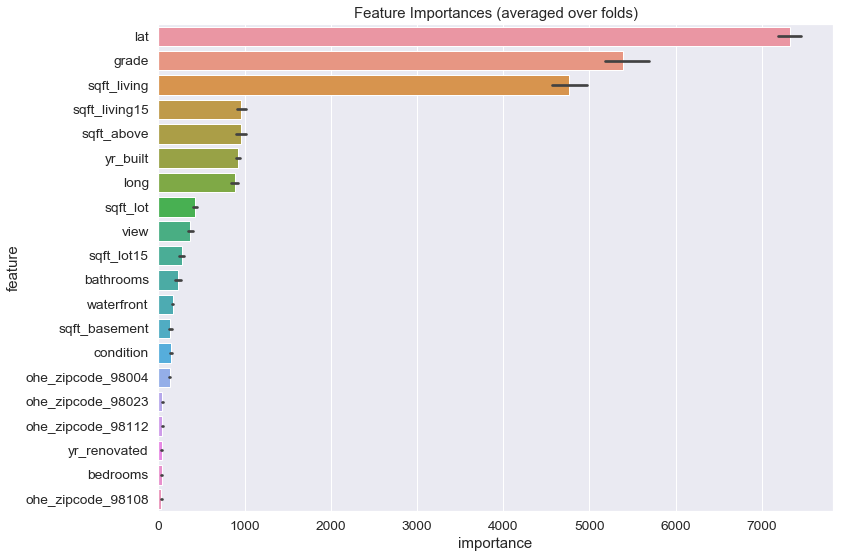

In [55]:
plot_feature_importance(fi_df)

## K-Means Clustering - Lat, Long
K-Means Clustering은 Clustering에 사용되는 비지도학습 알고리즘 중의 하나입니다. 위도, 경도 데이터를 K-Means Clustering 하면 가까운 지역끼리 Cluster가 만들어지기 때문에 zipcode와 유사한 개념의 새로운 feature를 만들 수 있습니다.

## Determine K by Elbow method
K-Means Clustering에서 중요한 건 K 값을 어떻게 결정하느냐 인데요. 일반적으로 많이 쓰이는 방법은 K 값을 늘려가면서 여러 개 돌려보면, Cluster 간의 거리의 합을 나타내는 inertia가 급격히 떨어지는 구간이 생기는데 이 지점의 K 값을 많이 사용합니다. 이런 방식을 Elbow Method라고 합니다. 먼저 Elbow Method를 통해 K 값을 결정해보겠습니다.

In [56]:
# inertia_arr = []

# k_range = range(2, 16)

# for k in k_range:
#     kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED).fit(coord)
 
#     # Sum of distances of samples to their closest cluster center
#     interia = kmeans.inertia_
#     print ("k:",k, " cost:", interia)
#     inertia_arr.append(interia)
    
# inertia_arr = np.array(inertia_arr)

# plt.plot(k_range, inertia_arr)
# plt.vlines(5, ymin=inertia_arr.min()*0.9999, ymax=inertia_arr.max()*1.0003, linestyles='--', colors='b')
# plt.title('Elbow Method')
# plt.xlabel('Number of clusters')
# plt.ylabel('Inertia');

In [57]:
# data = load_original_data()

# # kmeans for lat, long
# kmeans = KMeans(n_clusters=5, random_state=RANDOM_SEED).fit(coord)
# coord_cluster = kmeans.predict(coord)
# data['coord_cluster'] = coord_cluster
# data['coord_cluster'] = data['coord_cluster'].map(lambda x: 'c_' + str(x).rjust(2, '0'))

# X_train, X_test, y_train = train_test_split(data)
# print(X_train.shape, X_test.shape)

In [58]:

# lgb_param = {
#     'objective': 'regression',
#     'learning_rate': 0.05,
#     'num_leaves': 15,
#     'bagging_fraction': 0.7,
#     'bagging_freq': 1,
#     'feature_fraction': 0.7,
#     'seed': RANDOM_SEED,
#     'metric': ['rmse'],
# }

# oof, pred, cv_score, fi_df = get_oof_lgb(X_train, y_train, X_test, lgb_param)

In [59]:
# # kmeans for lat, long
# kmeans = KMeans(n_clusters=32, random_state=RANDOM_SEED).fit(coord)
# coord_cluster = kmeans.predict(coord)
# data['coord_cluster'] = coord_cluster
# data['coord_cluster'] = data['coord_cluster'].map(lambda x: 'c_' + str(x).rjust(2, '0'))

In [60]:
train.shape

(15029, 32)

In [61]:
test.shape

(6468, 31)

In [62]:
# #결국 이게 결과.
# kmeans = KMeans(n_clusters=32, random_state=RANDOM_SEED).fit(coord)
# coord_cluster = kmeans.predict(coord)

In [63]:
#결국 이게 결과.
kmeans = KMeans(n_clusters=32, random_state=RANDOM_SEED).fit(coord1)
coord_cluster1 = kmeans.predict(coord1)

train['coord_cluster'] = coord_cluster1
train['coord_cluster'] = train['coord_cluster'].map(lambda x: 'c_' + str(x).rjust(2, '0'))

In [64]:
#결국 이게 결과.
kmeans = KMeans(n_clusters=32, random_state=RANDOM_SEED).fit(coord2)
coord_cluster2 = kmeans.predict(coord2)

test['coord_cluster'] = coord_cluster2
test['coord_cluster'] = test['coord_cluster'].map(lambda x: 'c_' + str(x).rjust(2, '0'))

In [65]:
# train['coord_cluster'] = coord_cluster
# train['coord_cluster'] = train['coord_cluster'].map(lambda x: 'c_' + str(x).rjust(2, '0'))

In [66]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,total_rooms,sqft_total_size,is_renovated,zipcode-3,zipcode-4,zipcode-5,zipcode-34,zipcode-45,zipcode-35,coord_pca1,coord_pca2,coord_cluster
0,0,20141013T000000,12.309987,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,1955.0,98178,47.5112,-122.257,1340,5650,4.00,1180,0,z_1,z_7,z_8,z_17,z_78,z_18,-0.001026,-0.065771,c_13
1,1,20150225T000000,12.100718,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,1933.0,98028,47.7379,-122.233,2720,8062,3.00,770,0,z_0,z_2,z_8,z_02,z_28,z_08,-0.129226,0.122733,c_22
2,2,20150218T000000,13.142168,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,1987.0,98074,47.6168,-122.045,1800,7503,5.00,1680,0,z_0,z_7,z_4,z_07,z_74,z_04,0.092501,0.151826,c_15
3,3,20140627T000000,12.458779,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,1995.0,98003,47.3097,-122.327,2238,6819,5.25,1715,0,z_0,z_0,z_3,z_00,z_03,z_03,0.075786,-0.264774,c_20
4,4,20150115T000000,12.583999,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,1963.0,98198,47.4095,-122.315,1650,9711,4.50,1060,0,z_1,z_9,z_8,z_19,z_98,z_18,0.020443,-0.180862,c_18


## Haversine Distance
마지막으로 Haversine Distance를 사용한 feature 생성입니다. Haversine Distance는 두 개의 위도, 경도 좌표에서 지구의 곡률을 고려해 두 좌표 간의 거리를 구하는 방법입니다.

아래의 function으로 Haversine Distance를 구할 수 있습니다.



In [67]:
def haversine_array(lat1, lng1, lat2, lng2): 
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2)) 
    AVG_EARTH_RADIUS = 6371 # in km 
    lat = lat2 - lat1 
    lng = lng2 - lng1 
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2 
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d)) 
    return h

주어진 데이터에서 위도, 경도의 최소값과, 최대값 두 개의 좌표에 대해 거리를 구해보면 113.88km가 나오는데, 가장 먼 거리의 거리가 이 정도라는 얘기가 되겠네요.

In [68]:
print(data['lat'].min(), data['lat'].max(), data['long'].min(), data['long'].max())

haversine_dist = haversine_array(data['lat'].min(), data['long'].min(), data['lat'].max(), data['long'].max())
print(f'max distance: {haversine_dist:.2f}km')

47.1559 47.7776 -122.519 -121.315
max distance: 113.88km


아래는 id가 0인 집과 전체 집과의 거리를 구한 데이터입니다. 0번 집과 가까운 이웃은 집값이 비슷할 확률이 높기 때문에 거리를 기반으로 가까운 이웃집의 데이터를 찾을 수 있습니다. 이런 식으로 전체 집들의 Haversine Distance를 구하면 나와 가까운 이웃집들의 정보를 새로운 feature로 활용할 수 있습니다.

In [69]:
neighbor_df = pd.DataFrame()
lat2 = data['lat'].values
long2 = data['long'].values

lat1 = data.loc[0, 'lat'] # id = 0 house lat
long1 = data.loc[0, 'long'] # id = 0 house long
dist_arr = haversine_array(lat1, long1, lat2, long2)
neighbor_df = pd.DataFrame({
    'id': np.tile(np.array([data.loc[0, 'id']]), data.shape[0]),
    'neighbor_id': data['id'],
    'neighbor_lat': lat2,
    'neighbor_long': long2,
    'distance': dist_arr,
})
    
print(neighbor_df.shape)
neighbor_df.head()

(21502, 5)


,id,neighbor_id,neighbor_lat,neighbor_long,distance
0,0,0,47.5112,-122.257,0.000000
1,0,1,47.7379,-122.233,25.271977
2,0,2,47.6168,-122.045,19.771055
3,0,3,47.3097,-122.327,23.016635
4,0,4,47.4095,-122.315,12.120049


# 모델링


In [70]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [71]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_df.values)
    rmse= np.sqrt(-cross_val_score(model, train_df.values, train_df_Y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [72]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [73]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [74]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [75]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [76]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)


In [77]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [78]:
train_df = train
test_df = test
train_df_Y = train['price']
train_df=train_df.drop(['id','price','date'], axis=1)
test_df=test_df.drop(['id','date'], axis=1)
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)

In [79]:
train_df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,total_rooms,sqft_total_size,is_renovated,coord_pca1,coord_pca2,zipcode_98001,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,zipcode-3_z_0,zipcode-3_z_1,zipcode-4_z_0,zipcode-4_z_1,zipcode-4_z_2,zipcode-4_z_3,zipcode-4_z_4,zipcode-4_z_5,zipcode-4_z_6,zipcode-4_z_7,zipcode-4_z_8,zipcode-4_z_9,zipcode-5_z_0,zipcode-5_z_1,zipcode-5_z_2,zipcode-5_z_3,zipcode-5_z_4,zipcode-5_z_5,zipcode-5_z_6,zipcode-5_z_7,zipcode-5_z_8,zipcode-5_z_9,zipcode-34_z_00,zipcode-34_z_01,zipcode-34_z_02,zipcode-34_z_03,zipcode-34_z_04,zipcode-34_z_05,zipcode-34_z_06,zipcode-34_z_07,zipcode-34_z_09,zipcode-34_z_10,zipcode-34_z_11,zipcode-34_z_12,zipcode-34_z_13,zipcode-34_z_14,zipcode-34_z_15,zipcode-34_z_16,zipcode-34_z_17,zipcode-34_z_18,zipcode-34_z_19,zipcode-45_z_01,zipcode-45_z_02,zipcode-45_z_03,zipcode-45_z_04,zipcode-45_z_05,zipcode-45_z_06,zipcode-45_z_07,zipcode-45_z_08,zipcode-45_z_09,zipcode-45_z_10,zipcode-45_z_11,zipcode-45_z_12,zipcode-45_z_14,zipcode-45_z_15,zipcode-45_z_16,zipcode-45_z_17,zipcode-45_z_18,zipcode-45_z_19,zipcode-45_z_22,zipcode-45_z_23,zipcode-45_z_24,zipcode-45_z_25,zipcode-45_z_26,zipcode-45_z_27,zipcode-45_z_28,zipcode-45_z_29,zipcode-45_z_30,zipcode-45_z_31,zipcode-45_z_32,zipcode-45_z_33,zipcode-45_z_34,zipcode-45_z_36,zipcode-45_z_38,zipcode-45_z_39,zipcode-45_z_40,zipcode-45_z_42,zipcode-45_z_44,zipcode-45_z_45,zipcode-45_z_46,zipcode-45_z_48,zipcode-45_z_52,zipcode-45_z_53,zipcode-45_z_55,zipcode-45_z_56,zipcode-45_z_58,zipcode-45_z_59,zipcode-45_z_65,zipcode-45_z_66,zipcode-45_z_68,zipcode-45_z_70,zipcode-45_z_72,zipcode-45_z_74,zipcode-45_z_75,zipcode-45_z_77,zipcode-45_z_78,zipcode-45_z_88,zipcode-45_z_92,zipcode-45_z_98,zipcode-45_z_99,zipcode-35_z_00,zipcode-35_z_01,zipcode-35_z_02,zipcode-35_z_03,zipcode-35_z_04,zipcode-35_z_05,zipcode-35_z_06,zipcode-35_z_07,zipcode-35_z_08,zipcode-35_z_09,zipcode-35_z_12,zipcode-35_z_13,zipcode-35_z_14,zipcode-35_z_15,zipcode-35_z_16,zipcode-35_z_17,zipcode-35_z_18,zipcode-35_z_19,coord_cluster_c_00,coord_cluster_c_01,coord_cluster_c_02,coord_cluster_c_03,coord_cluster_c_04,coord_cluster_c_05,coord_cluster_c_06,coord_cluster_c_07,coord_cluster_c_08,coord_cluster_c_09,coord_cluster_c_10,coord_cluster_c_11,coord_cluster_c_12,coord_cluster_c_13,coord_cluster_c_14,coord_cluster_c_15,coord_cluster_c_16,coord_cluster_c_17,coord_cluster_c_18,coord_cluster_c_19,coord_cluster_c_20,coord_cluster_c_21,coord_cluster_c_22,coord_cluster_c_23,coord_cluster_c_24,coord_cluster_c_25,coord_cluster_c_26,coord_cluster_c_27,coord_cluster_c_28,coord_cluster_c_29,coord_cluster_c_30,coord_cluster_c_31
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,1955.0,47.5112,-122.257,1340,5650,4.00,1180,0,-0.001026,-0.065771,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0

In [80]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1888 (0.0042)



In [81]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1881 (0.0042)



score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [82]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1586 (0.0064)



In [83]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1601 (0.0060)



In [84]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1656 (0.0064)



In [85]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [ ]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# Loading packages
import pandas as pd #Analysis 
import matplotlib.pyplot as plt #Visulization
import seaborn as sns #Visulization
import numpy as np #Analysis 
from scipy.stats import norm #Analysis 
from sklearn.preprocessing import StandardScaler #Analysis 
from scipy import stats #Analysis 
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
import gc

import lightgbm as lgb
import xgboost as xgb
import catboost as cb

import time
from datetime import datetime, timedelta,date

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler

def check_train_test_diff(train, test, col):
    ratio_df = pd.concat([train[col].value_counts()/train.shape[0], test[col].value_counts()/test.shape[0]], axis=1)
    ratio_df.columns = ['train','test']
    ratio_df['diff'] = ratio_df['train'] - ratio_df['test']
    return ratio_df

def category_feature_distribution(train, col, target='price'):
    fig, ax = plt.subplots(1, 2, figsize=(16,4))
    
    for c in sorted(train[col].unique()):
        sns.distplot(np.log1p(train.loc[train[col]==c, target]), ax=ax[0])
    ax[0].legend(sorted(train[col].unique()))
    ax[0].set_title(f'{col} {target} distribution')

    sns.boxplot(x=col, y=target, data=df_train, ax=ax[1])
    ax[1].set_title(f'{col} vs {target}')
    
    plt.show()

def continous_feature_distribution(train, test, col, target='price'):
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    
    sns.distplot(train[col], ax=ax[0])
    sns.distplot(test[col], ax=ax[0])
    ax[0].set_title(f'{col} - train/test distribution')
    
    sns.scatterplot(x=col, y=target, data=train, ax=ax[1])
    ax[1].set_title(f'{col} - {target} scatterplot')
    
    plt.show()

def scatter_quantile_graph(frame, col1, col2):
    col1_quantile = np.arange(0,1.1,0.1)
    col2_quantile = np.arange(0,1.1,0.1)

    for quantile_value in frame[col1].quantile(col1_quantile):
        plt.axvline(quantile_value, color='red', alpha=0.3)
    for quantile_value in frame[col2].quantile(col2_quantile):
        plt.axhline(quantile_value, color='blue', alpha=0.3)
        
    sns.scatterplot(col1, col2, hue='price',data=frame)
    
    plt.title('{} - {}'.format(col1,col2))
    plt.show()

def get_prefix(group_col, target_col, prefix=None):
    if isinstance(group_col, list) is True:
        g = '_'.join(group_col)
    else:
        g = group_col
    if isinstance(target_col, list) is True:
        t = '_'.join(target_col)
    else:
        t = target_col
    if prefix is not None:
        return prefix + '_' + g + '_' + t
    return g + '_' + t
    
def groupby_helper(df, group_col, target_col, agg_method, prefix_param=None):
    try:
        prefix = get_prefix(group_col, target_col, prefix_param)
        print(group_col, target_col, agg_method)
        group_df = df.groupby(group_col)[target_col].agg(agg_method)
        group_df.columns = ['{}_{}'.format(prefix, m) for m in agg_method]
    except BaseException as e:
        print(e)
    return group_df.reset_index()

from functools import wraps
def time_decorator(func): 
    @wraps(func)
    def wrapper(*args, **kwargs):
        print("\nStartTime: ", datetime.now() + timedelta(hours=9))
        start_time = time.time()
        
        df = func(*args, **kwargs)
        
        print("EndTime: ", datetime.now() + timedelta(hours=9))  
        print("TotalTime: ", time.time() - start_time)
        return df
        
    return wrapper

class SklearnWrapper(object):
    def __init__(self, clf, params=None, **kwargs):
        #if isinstance(SVR) is False:
        #    params['random_state'] = kwargs.get('seed', 0)
        self.clf = clf(**params)
        self.is_classification_problem = True
    @time_decorator
    def train(self, x_train, y_train, x_cross=None, y_cross=None):
        if len(np.unique(y_train)) > 30:
            self.is_classification_problem = False
            
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        if self.is_classification_problem is True:
            return self.clf.predict_proba(x)[:,1]
        else:
            return self.clf.predict(x)   
    
class XgbWrapper(object):
    def __init__(self, params=None, **kwargs):
        self.param = params
        self.param['seed'] = kwargs.get('seed', 0)
        self.num_rounds = kwargs.get('num_rounds', 1000)
        self.early_stopping = kwargs.get('ealry_stopping', 100)

        self.eval_function = kwargs.get('eval_function', None)
        self.verbose_eval = kwargs.get('verbose_eval', 100)
        self.best_round = 0
    
    @time_decorator
    def train(self, x_train, y_train, x_cross=None, y_cross=None):
        need_cross_validation = True
       
        if isinstance(y_train, pd.DataFrame) is True:
            y_train = y_train[y_train.columns[0]]
            if y_cross is not None:
                y_cross = y_cross[y_cross.columns[0]]

        if x_cross is None:
            dtrain = xgb.DMatrix(x_train, label=y_train, silent= True)
            train_round = self.best_round
            if self.best_round == 0:
                train_round = self.num_rounds
            
            print(train_round)
            self.clf = xgb.train(self.param, dtrain, train_round)
            del dtrain
        else:
            dtrain = xgb.DMatrix(x_train, label=y_train, silent=True)
            dvalid = xgb.DMatrix(x_cross, label=y_cross, silent=True)
            watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

            self.clf = xgb.train(self.param, dtrain, self.num_rounds, watchlist, feval=self.eval_function,
                                 early_stopping_rounds=self.early_stopping,
                                 verbose_eval=self.verbose_eval)
            self.best_round = max(self.best_round, self.clf.best_iteration)

    def predict(self, x):
        return self.clf.predict(xgb.DMatrix(x), ntree_limit=self.best_round)

    def get_params(self):
        return self.param    
    
class LgbmWrapper(object):
    def __init__(self, params=None, **kwargs):
        self.param = params
        self.param['seed'] = kwargs.get('seed', 0)
        self.num_rounds = kwargs.get('num_rounds', 1000)
        self.early_stopping = kwargs.get('ealry_stopping', 100)

        self.eval_function = kwargs.get('eval_function', None)
        self.verbose_eval = kwargs.get('verbose_eval', 100)
        self.best_round = 0
        
    @time_decorator
    def train(self, x_train, y_train, x_cross=None, y_cross=None):
        """
        x_cross or y_cross is None
        -> model train limted num_rounds
        
        x_cross and y_cross is Not None
        -> model train using validation set
        """
        if isinstance(y_train, pd.DataFrame) is True:
            y_train = y_train[y_train.columns[0]]
            if y_cross is not None:
                y_cross = y_cross[y_cross.columns[0]]

        if x_cross is None:
            dtrain = lgb.Dataset(x_train, label=y_train, silent= True)
            train_round = self.best_round
            if self.best_round == 0:
                train_round = self.num_rounds
                
            self.clf = lgb.train(self.param, train_set=dtrain, num_boost_round=train_round)
            del dtrain   
        else:
            dtrain = lgb.Dataset(x_train, label=y_train, silent=True)
            dvalid = lgb.Dataset(x_cross, label=y_cross, silent=True)
            self.clf = lgb.train(self.param, train_set=dtrain, num_boost_round=self.num_rounds, valid_sets=[dtrain, dvalid],
                                  feval=self.eval_function, early_stopping_rounds=self.early_stopping,
                                  verbose_eval=self.verbose_eval)
            self.best_round = max(self.best_round, self.clf.best_iteration)
            del dtrain, dvalid
            
        gc.collect()
    
    def predict(self, x):
        return self.clf.predict(x, num_iteration=self.clf.best_iteration)
    
    def plot_importance(self):
        lgb.plot_importance(self.clf, max_num_features=50, height=0.7, figsize=(10,30))
        plt.show()
        
    def get_params(self):
        return self.param
    
    
@time_decorator
def get_oof(clf, x_train, y_train, x_test, eval_func, **kwargs):
    nfolds = kwargs.get('NFOLDS', 5)
    kfold_shuffle = kwargs.get('kfold_shuffle', True)
    kfold_random_state = kwargs.get('kfold_random_state', 0)
    stratified_kfold_ytrain = kwargs.get('stratifed_kfold_y_value', None)
    ntrain = x_train.shape[0]
    ntest = x_test.shape[0]
    
    kf_split = None
    if stratified_kfold_ytrain is None:
        kf = KFold(n_splits=nfolds, shuffle=kfold_shuffle, random_state=kfold_random_state)
        kf_split = kf.split(x_train)
    else:
        kf = StratifiedKFold(n_splits=nfolds, shuffle=kfold_shuffle, random_state=kfold_random_state)
        kf_split = kf.split(x_train, stratified_kfold_ytrain)
        
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))

    cv_sum = 0
    
    # before running model, print model param
    # lightgbm model and xgboost model use get_params()
    try:
        if clf.clf is not None:
            print(clf.clf)
    except:
        print(clf)
        print(clf.get_params())

    for i, (train_index, cross_index) in enumerate(kf_split):
        x_tr, x_cr = None, None
        y_tr, y_cr = None, None
        if isinstance(x_train, pd.DataFrame):
            x_tr, x_cr = x_train.iloc[train_index], x_train.iloc[cross_index]
            y_tr, y_cr = y_train.iloc[train_index], y_train.iloc[cross_index]
        else:
            x_tr, x_cr = x_train[train_index], x_train[cross_index]
            y_tr, y_cr = y_train[train_index], y_train[cross_index]

        clf.train(x_tr, y_tr, x_cr, y_cr)
        
        oof_train[cross_index] = clf.predict(x_cr)

        cv_score = eval_func(y_cr, oof_train[cross_index])
        
        print('Fold %d / ' % (i+1), 'CV-Score: %.6f' % cv_score)
        cv_sum = cv_sum + cv_score
        
        del x_tr, x_cr, y_tr, y_cr
        
    gc.collect()
    
    score = cv_sum / nfolds
    print("Average CV-Score: ", score)

    # Using All Dataset, retrain
    clf.train(x_train, y_train)
    oof_test = clf.predict(x_test)

    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1), score

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

df_train = train
df_test = test

train_ID = train['id']
test_ID = df_test['id']

train.head(1)


df_train.drop("date", axis = 1, inplace = True)
df_test.drop("date", axis = 1, inplace = True)

df_train.drop("price", axis = 1, inplace = True)

train.head(5)

# test

# 테스트 세트
train_df = train
test_df = test
train_df_Y = train['price']
train_df=train_df.drop(['id','price','date'], axis=1)
test_df=test_df.drop(['id','date'], axis=1)
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)

lgb_param = {
    'objective': 'regression',
    'learning_rate': 0.05,
    'num_leaves': 15,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'feature_fraction': 0.7,
    'seed': RANDOM_SEED,
    'metric': ['rmse'],
}

oof, pred, cv_score, fi_df = get_oof_lgb(train_df, train_df_Y, test_df, lgb_param)

train.head()

train_df = train
test_df = test

train_ID = train['id']
test_ID = df_test['id']

train_df_Y = train['price']
train_df=train_df.drop(['id','price','date'], axis=1)
test_df=test_df.drop(['id','date'], axis=1)
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)

train_df = train
test_df = test

train_ID = train_df['id']
test_ID = test_df['id']


train_df_Y = train['price']
train_df=train_df.drop(['id','price','date'], axis=1)
test_df=test_df.drop(['id','date'], axis=1)
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)


lgb_param = {
    'objective': 'regression',
    'learning_rate': 0.05,
    'num_leaves': 15,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'feature_fraction': 0.7,
    'seed': RANDOM_SEED,
    'metric': ['rmse'],
}

oof, pred, cv_score, fi_df = get_oof_lgb(train_df, train_df_Y, test_df, lgb_param)

sub = pd.DataFrame()
sub['Id'] = test_ID
pred_f = np.expm1(pred)
sub['price'] = pred_f
sub.to_csv('KR_submission_2.csv',index=False)

plot_feature_importance(fi_df)

train_df=train_df.drop(['id','price'], axis=1)
test_df=test_df.drop(['id'], axis=1)

for df_t in [train_df,test_df]:
    cat_cols = df_t.select_dtypes('object').columns
    for col in cat_cols:
        ohe_df = pd.get_dummies(df_t[[col]], prefix='ohe_'+col)
        df_t.drop(col, axis=1, inplace=True)
        df_t = pd.concat([df_t, ohe_df], axis=1)

train_df.head()

train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)

lgb_param = {
    'objective': 'regression',
    'learning_rate': 0.05,
    'num_leaves': 15,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'feature_fraction': 0.7,
    'seed': RANDOM_SEED,
    'metric': ['rmse'],
}

oof, pred, cv_score, fi_df = get_oof_lgb(train_df, train_df_Y, test_df, lgb_param)

df_train = train
df_test = test

df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

# for df in [df_train,df_test]:
#     cat_cols = df.select_dtypes('object').columns
#     for col in cat_cols:
#             df = pd.get_dummies(df[[col]], prefix='ohe_'+col)
# #             df.drop(col, axis=1, inplace=True)
# #             df = pd.concat([df, ohe_df], axis=1)

train_df.head(1)

#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, df_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [86]:
# all_df = pd.concat([df_train, df_test])

In [87]:
# df_test = all_df.loc[all_df['price'].isnull()]
# df_train = all_df.loc[all_df['price'].notnull()]

In [88]:
# train_columns = [col for col in df_train.columns if col not in ['id','price']]

# x_train = df_train.copy()
# y_train = np.log1p(df_train['price'])
# del x_train['price']
# x_test = df_test.copy()

In [89]:
# def rmse(y_true, y_pred):
#     return np.sqrt(mean_squared_error(np.expm1(y_true), np.expm1(y_pred)))

In [90]:
# lgb_param = {'num_leaves': 31,
#          'min_data_in_leaf': 30, 
#          'objective':'regression',
#          'max_depth': -1,
#          'learning_rate': 0.015,
#          "min_child_samples": 20,
#          "boosting": "gbdt",
#          "feature_fraction": 0.9,
#          "bagging_freq": 1,
#          "bagging_fraction": 0.9 ,
#          "bagging_seed": 11,
#          "metric": 'rmse',
#          "lambda_l1": 0.1,
#          "verbosity": -1,
#          "nthread": 4,
#          "random_state": 4950}

# xgb_params = {
#     'eval_metric': 'rmse',
#     'seed': 4950,
#     'eta': 0.0123,
#     'gamma':0,
#     'max_depth':3,
#     'reg_alpha':0.00006,
#     'subsample': 0.7,
#     'colsample_bytree': 0.7,
#     'silent': 1,
# }

# ridge_params = {'alpha':0.0001, 'normalize':True, 'max_iter':1e7, 'random_state':0}
# lasso_params = {'alpha':0.0005, 'normalize':True, 'max_iter':1e7, 'random_state':0}
# elastic_params = {'alpha':0.001, 'normalize':True, 'max_iter':1e3, 'random_state':0, 'l1_ratio':0.8}
# svr_param = {'C':20, 'epsilon':0.008, 'gamma':0.0003}
# gbr_param = {'n_estimators':3000, 'learning_rate':0.05, 'max_depth':4, 'max_features':'sqrt', 'min_samples_leaf':15, 'min_samples_split':10, 'loss':'huber', 'random_state':0 }

In [91]:
# xgb_model = XgbWrapper(params=xgb_params, num_rounds = 10000, ealry_stopping=100,
#                                    verbose_eval=100)

# lgb_model = LgbmWrapper(params=lgb_param, num_rounds = 10000, ealry_stopping=100,
#                                    verbose_eval=100)

# ridge_model = SklearnWrapper(Ridge, params=ridge_params)
# lasso_model = SklearnWrapper(Lasso, params=lasso_params)
# elastic_model = SklearnWrapper(ElasticNet, params=lasso_params)
# svr_model = SklearnWrapper(SVR, params=svr_param)
# gbr_model = SklearnWrapper(GradientBoostingRegressor, params=gbr_param)

In [92]:
# x_train_rb = x_train.copy()
# x_test_rb = x_test.copy()
# rb = RobustScaler()
# x_train_rb[train_columns] = rb.fit_transform(x_train_rb[train_columns].fillna(-1))
# x_test_rb[train_columns] = rb.transform(x_test_rb[train_columns].fillna(-1))